# openelec example walkthrough

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium

from openelec.clustering import prepare_clusters
from openelec.local import LocalModel
from openelec.national import NationalModel

# Prepare clusters

In [ ]:
folder_input = Path.home() / 'Documents/GIS'
ghs_in = folder_input / 'GHS_POP_250.tif'
gdp_in = folder_input / 'GDP.tif'
travel_in = folder_input / 'Travel.tif'
ntl_in = folder_input / 'VIIRS_Africa_2016.tif'
aoi_in = folder_input / 'gadm.gpkg'
grid_in = folder_input / 'africagrid.gpkg'

folder_output = Path.home() / f'Code/openelec-api/openelec_api/static/lesotho'
clusters_out = folder_output / 'clusters.geojson'

clusters = prepare_clusters(country,
                            ghs_in=ghs_in,
                            gdp_in=gdp_in,
                            travel_in=travel_in,
                            ntl_in=ntl_in,
                            aoi_in=aoi_in,
                            grid_in=grid_in,
                            clusters_out=clusters_out)   

# National

In [3]:
clusters_in = Path('test_data/clusters.geojson')
national_out = Path('test_output/national')

In [27]:
nm = NationalModel(data=clusters_in)
nm.parameters(demand=6,              # kWh/person/month
              actual_pop=2.2e6,      # current population (NOT USED)
              pop_growth=0.01,       # % (NOT USED)
              people_per_hh=5,       # 
              
              grid_mv_cost=50,       # USD/m
              grid_lv_cost=3,        # USD/m
              grid_trans_cost=3500,  # USD/unit
              grid_conn_cost=200,    # USD/hh
              grid_opex_ratio=0.02,  # % of capex (NOT USED)
              
              mg_gen_cost=4000,      # USD/kW
              mg_lv_cost=2,          # USD/m
              mg_conn_cost=100,      # USD/hh
              mg_opex_ratio=0.02,    # % of capex (NOT USED)
              
              access_tot=0.30,       # total access rate
              access_urban=0.66,     # urban access rate
              
              grid_dist_connected=2, # km, less considered connected
              minimum_pop=100,       # exclude any population below this
              min_ntl_connected=0)   # shouldn't be used if using initial_access()

In [28]:
nm.setup(sort_by='pop')

In [29]:
nm.initial_access()

Access rate error: 1%


In [30]:
nm.demand_levels(factor=5)

In [45]:
nm.connect_targets()

In [46]:
nm.model()

In [47]:
nm.spatialise()

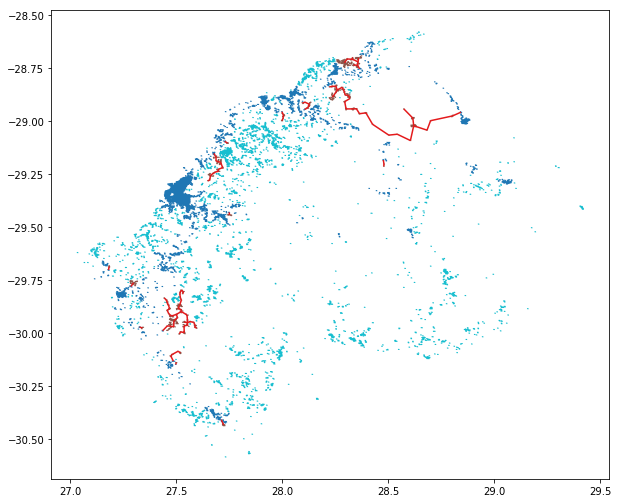

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
nm.network_out.plot(ax=ax, column='existing', cmap='Set1')
nm.targets_out.plot(ax=ax, column='type', cmap='tab10')
plt.show()

In [49]:
nm.save_to_path(national_out)
print('Results saved to', national_out.absolute())

/home/chris/.envs/openelec/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Results saved to /home/chris/Code/openelec/test_output/national


In [ ]:
results = nm.summary()

print(f'New grid: {results["new-grid"]} at cost {results["cost-grid"]:,.0f}')
print(f'New off-grid: {results["new-off-grid"]} at cost {results["cost-off-grid"]:,.0f}')
print(f'Densify: {results["densify"]} at cost {results["cost-densify"]:,.0f}')
print()
print(f'Total cost ${results["tot-cost"]:,.0f}')
print()
print(f'Modelled pop: {results["model-pop"]:,.0f}')
print(f'Currently electrified pop: {results["already-elec-pop"]:,.0f}')
print(f'Densify pop: {results["densify-pop"]:,.0f}')
print(f'New extentions pop: {results["new-conn-pop"]:,.0f}')
print(f'Off-grid pop: {results["new-og-pop"]:,.0f}')

# Local

In [ ]:
buildings_in = Path('test_data/buildings.geojson')
local_out = Path('test_output/local')

In [ ]:
lm = LocalModel(data=buildings_in)
lm.setup(sort_by='area',
         min_area=0)  # m2, exclude buildings with area below this

In [ ]:
m = folium.Map([lm.y_mean, lm.x_mean],
               zoom_start=15,
               control_scale=True)

popup_html = '<p>Latitude: " + lat + "</p><p>Longitude: " + lng + "</p>'
folium.ClickForMarker(popup=popup_html).add_to(m)
folium.GeoJson(lm.targets).add_to(m)
display(Markdown('### Click on the desired location for the PV point.'))
m

In [ ]:
latitude = -29.5432
longitude = 28.1339

In [ ]:
lm.connect_targets(origin=(latitude, longitude))

In [ ]:
lm.parameters(demand=8,             # average demand in kWh/person/month
              tariff=0.2,          # USD/kWh charged
              gen_cost=4000,        # USD/kW for installation, excluding distribution network
              cost_wire=20,         # USD per metre
              cost_connection=140,  # USD per connection/node
              opex_ratio=0.02,      # % of capex per year (values above 1 are divided by 100)
              years=20,             # years over which to amortize (and maintain)
              discount_rate=0.06)   # discount rate (values above 1 are divided by 100)

In [ ]:
lm.model()

In [ ]:
lm.spatialise()

fig, ax = plt.subplots(figsize=(10,10))
lm.network_out.loc[lm.network_out['enabled'] == 1].plot(ax=ax, color='red')
lm.targets_out.plot(ax=ax, color='blue')
ax.scatter(longitude, latitude, s=200, lw=0, c='green')
plt.show()

In [ ]:
lm.save_to_path(local_out)
print('Results saved to', local_out.absolute())

In [ ]:
results = lm.summary()
print(f'Total houses connected: {results["connected"]} out of {len(lm.targets_out)-1}')
print(f'Generator installation size: {results["gen-size"]:.0f} kW')
print(f'Total length of lines is {results["line-length"]:.0f}m')
print(f'CAPEX: ${results["capex"]:.0f}')
print(f'Annual OPEX: ${results["opex"]:.0f}')
print(f'Annual Income: ${results["income"]:.0f}')
print(f'NPV over {lm.years} years is ${lm.results["npv"]:.0f}')